In [32]:
!nvidia-smi
!ps -aux|grep python

Sun Jun  7 14:47:00 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   69C    P0    32W /  70W |   5045MiB / 15079MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
!kill -9 573

In [1]:
import tensorflow as tf

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [3]:
!pip install transformers

     |████████████████████████████████| 675kB 8.3MB/s 
     |████████████████████████████████| 1.1MB 22.1MB/s 
     |████████████████████████████████| 890kB 48.2MB/s 
     |████████████████████████████████| 3.8MB 35.2MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893260 sha256=a6e82155ae8cf847256c08619ae241c03c76933261ae62f3ab754151b7cbbe77
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [2]:
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split


from transformers import XLNetModel, XLNetTokenizer, XLNetForSequenceClassification
from transformers import AdamW

from tqdm import tqdm, trange
import pandas as pd
import io
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline

Using TensorFlow backend.


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)

'Tesla T4'

In [7]:
# Upload the train file from your local drive
from google.colab import files
uploaded = files.upload()

Saving final_lean_sample.pkl to final_lean_sample.pkl


In [0]:
df_original = pd.read_pickle("./final_lean_sample.pkl")
df = df_original[:6361]

In [5]:
df.shape

(6361, 2)

In [6]:
df.sample(10)

,sales_sentiment,text
121266,1,"- April 20, 2005 - LaSalle Hotel Properties (..."
27255,1,"--May 9, 1994--Stone Energy (NYSE:SGY) reporte..."
125417,0,"- April 26, 2006 - All financial information ..."
112250,1,"- April 27, 2004 -\n\nCompany Posts Record Qu..."
115751,0,"\nNORTH CHELMSFORD, Mass.Courier Corporation (..."
88971,1,"--May 17, 2001--SIGA Technologies, Inc. (NASDA..."
91582,1,"--Nov. 15, 2001--Viseon, Inc. (OTCBB:VSNI), a ..."
174480,0,"--April 25, 2013-- \nRTI Biologics Inc. (RTI) ..."
30004,1,"--EZCORP, Inc. (Nasdaq/NM: EZPW) today announc..."
74091,0,"--Jan. 26, 1999--Health Systems Design Corp. (..."


In [0]:
sentences = df.text.values

In [0]:
sentences = [sentence + " [SEP] [CLS]" for sentence in sentences]
labels = df.sales_sentiment.values

In [9]:
tokenizer = XLNetTokenizer.from_pretrained('xlnet-base-cased', do_lower_case=True)

tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]
print ("Tokenize the first sentence:")
print (tokenized_texts[0])


Tokenize the first sentence:
['▁', '-', '-', 'ro', 'bert', '▁', 's', '.', '▁', 'w', 'iggins', ',', '▁chairman', '▁and', '▁chief', '▁executive', '▁officer', '▁of', '▁technology', '▁research', '▁', 'corp', '.', '▁', '(', 't', 'rc', ')', '▁', '(', 'nas', 'd', 'aq', ':', 'tr', 'ci', ')', ',', '▁', 'tu', 'es', 'day', '▁reported', '▁that', '▁the', '▁company', "'", 's', '▁revenues', '▁for', '▁the', '▁first', '▁quarter', '▁ended', '▁', 'jun', 'e', '▁30', '▁were', '▁$1', ',', '3', '79', ',', '99', '8', '▁compared', '▁to', '▁$1', ',', '94', '5', ',', '24', '5', '▁reported', '▁in', '▁the', '▁like', '▁quarter', '▁of', '▁the', '▁prior', '▁year', ',', '▁and', '▁the', '▁net', '▁loss', '▁for', '▁the', '▁current', '▁quarter', '▁was', '▁$39', '4', ',', '5', '25', '▁compared', '▁to', '▁net', '▁income', '▁of', '▁$10', ',', '4', '36', '▁for', '▁the', '▁prior', '▁year', "'", 's', '▁quarter', '.', 'w', 'iggins', '▁stated', '▁that', '▁sales', '▁of', '▁the', '▁company', "'", 's', '▁ground', '▁fault', '▁circuit

In [0]:
# Set the maximum sequence length. The longest sequence in our training set is 47, but we'll leave room on the end anyway. 
MAX_LEN = 512

In [0]:
# Use the XLNet tokenizer to convert the tokens to their index numbers in the XLNet vocabulary
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]

In [0]:
# Pad our input tokens
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

In [0]:
# Create attention masks
attention_masks = []

# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
  seq_mask = [float(i>0) for i in seq]
  attention_masks.append(seq_mask)

In [0]:
# Use train_test_split to split our data into train and validation sets for training

train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels, 
                                                            random_state=2018, test_size=1414)
train_masks, validation_masks, _, _ = train_test_split(attention_masks, input_ids,
                                             random_state=2018, test_size=1414)

In [0]:
# Convert all of our data into torch tensors, the required datatype for our model

train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)
train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)
train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

In [0]:
# Select a batch size for training. For fine-tuning with XLNet, the authors recommend a batch size of 32, 48, or 128. We will use 32 here to avoid memory issues.
batch_size = 8

# Create an iterator of our data with torch DataLoader. This helps save on memory during training because, unlike a for loop, 
# with an iterator the entire dataset does not need to be loaded into memory

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)


In [17]:
# Load XLNEtForSequenceClassification, the pretrained XLNet model with a single linear classification layer on top. 
model = XLNetForSequenceClassification.from_pretrained("xlnet-base-cased", num_labels=2)
model.cuda()

XLNetForSequenceClassification(
  (transformer): XLNetModel(
    (word_embedding): Embedding(32000, 768)
    (layer): ModuleList(
      (0): XLNetLayer(
        (rel_attn): XLNetRelativeAttention(
          (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (ff): XLNetFeedForward(
          (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (layer_1): Linear(in_features=768, out_features=3072, bias=True)
          (layer_2): Linear(in_features=3072, out_features=768, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (1): XLNetLayer(
        (rel_attn): XLNetRelativeAttention(
          (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (ff): XLNetFeedForward(
          (layer_norm): LayerNorm((768,), eps=1e

In [0]:
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]

In [0]:
# This variable contains all of the hyperparemeter information our training loop needs
optimizer = AdamW(optimizer_grouped_parameters,
                     lr=2e-5)

In [0]:
# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [21]:
# Store our loss and accuracy for plotting
train_loss_set = []

# Number of training epochs (authors recommend between 2 and 4)
epochs = 4

# trange is a tqdm wrapper around the normal python range
for _ in trange(epochs, desc="Epoch"):
  
  # Training
  
  # Set our model to training mode (as opposed to evaluation mode)
  model.train()
  
  # Tracking variables
  tr_loss = 0
  nb_tr_examples, nb_tr_steps = 0, 0

  
  # Train the data for one epoch
  for step, batch in enumerate(train_dataloader):
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    # Clear out the gradients (by default they accumulate)
    optimizer.zero_grad()
    # Forward pass
    outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
    loss = outputs[0]
    logits = outputs[1]
    train_loss_set.append(loss.item())    
    # Backward pass
    loss.backward()
    # Update parameters and take a step using the computed gradient
    optimizer.step()
    
    
    # Update tracking variables
    tr_loss += loss.item()
    nb_tr_examples += b_input_ids.size(0)
    nb_tr_steps += 1

  print("Train loss: {}".format(tr_loss/nb_tr_steps))
    
  # Validation

  # Put model in evaluation mode to evaluate loss on the validation set
  model.eval()

  # Tracking variables 
  eval_loss, eval_accuracy = 0, 0
  nb_eval_steps, nb_eval_examples = 0, 0

  # Evaluate data for one epoch
  for batch in validation_dataloader:
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    # Telling the model not to compute or store gradients, saving memory and speeding up validation
    with torch.no_grad():
      # Forward pass, calculate logit predictions
      output = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
      logits = output[0]
    
    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    tmp_eval_accuracy = flat_accuracy(logits, label_ids)
    
    eval_accuracy += tmp_eval_accuracy
    nb_eval_steps += 1

  print("Validation Accuracy: {}".format(eval_accuracy/nb_eval_steps))

Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Train loss: 0.7090775165496235


Epoch:  25%|██▌       | 1/4 [01:43<05:09, 103.26s/it]

Validation Accuracy: 0.5244821092278719
Train loss: 0.7035969420665685


Epoch:  50%|█████     | 2/4 [03:26<03:26, 103.30s/it]

Validation Accuracy: 0.4755178907721281
Train loss: 0.7021699041272597


Epoch:  75%|███████▌  | 3/4 [05:09<01:43, 103.29s/it]

Validation Accuracy: 0.5244821092278719
Train loss: 0.7019280216420409


Epoch: 100%|██████████| 4/4 [06:53<00:00, 103.30s/it]

Validation Accuracy: 0.5244821092278719


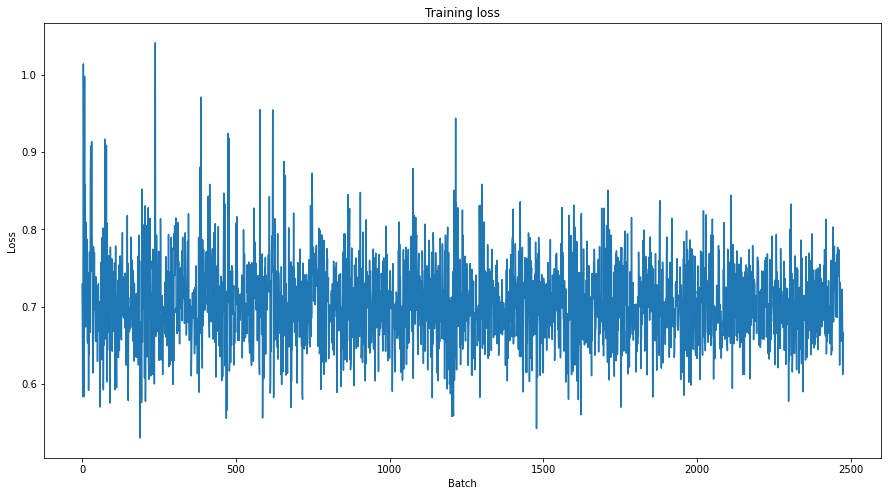

In [22]:
plt.figure(figsize=(15,8))
plt.title("Training loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.plot(train_loss_set)
plt.show()

In [0]:
#df = pd.read_csv("out_of_domain_dev.tsv", delimiter='\t', header=None, names=['sentence_source', 'label', 'label_notes', 'sentence'])
df = df_original[6361:]

# Create sentence and label lists
sentences = df.text.values

# We need to add special tokens at the beginning and end of each sentence for XLNet to work properly
sentences = [sentence + " [SEP] [CLS]" for sentence in sentences]
labels = df.sales_sentiment.values

tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]


#MAX_LEN = 512
# Use the XLNet tokenizer to convert the tokens to their index numbers in the XLNet vocabulary
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
# Pad our input tokens
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")
# Create attention masks
attention_masks = []

# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
  seq_mask = [float(i>0) for i in seq]
  attention_masks.append(seq_mask) 

prediction_inputs = torch.tensor(input_ids)
prediction_masks = torch.tensor(attention_masks)
prediction_labels = torch.tensor(labels)

#batch_size = 8


prediction_data = TensorDataset(prediction_inputs, prediction_masks, prediction_labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

In [0]:
# Prediction on test set

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions , true_labels = [], []

# Predict 
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch
  # Telling the model not to compute or store gradients, saving memory and speeding up prediction
  with torch.no_grad():
    # Forward pass, calculate logit predictions
    outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
    logits = outputs[0]

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  
  # Store predictions and true labels
  predictions.append(logits)
  true_labels.append(label_ids)

In [25]:
total_size = 0
correct_count = 0
for i in range(len(true_labels)):
  tl = true_labels[i]
  pl = np.argmax(predictions[i], axis=1).flatten()
  assert len(tl) == len(pl)
  
  total_size += len(tl)
  for i in range(len(tl)):
    if tl[i] == pl[i]:
      correct_count += 1
    
print("Total: {}, Correct: {}, Accuracy: {}".format(total_size, correct_count, correct_count/total_size))

Total: 707, Correct: 329, Accuracy: 0.46534653465346537


In [26]:
from sklearn.metrics import matthews_corrcoef, roc_auc_score

def auc_score(predictions, true_labels):
    # Combine the results across all batches. 
    flat_predictions = np.concatenate(predictions, axis=0)

    # For each sample, pick the label (0 or 1) with the higher score.
    flat_predictions = np.argmax(flat_predictions, axis=1).flatten()

    # Combine the correct labels for each batch into a single list.
    flat_true_labels = np.concatenate(true_labels, axis=0)

    return roc_auc_score(flat_true_labels, flat_predictions, average='weighted')


auc = auc_score(predictions, true_labels)
print("AUC Score: {}".format(auc))


AUC Score: 0.5


In [27]:
# Import and evaluate each test batch using Matthew's correlation coefficient
from sklearn.metrics import matthews_corrcoef
matthews_set = []

for i in range(len(true_labels)):
  matthews = matthews_corrcoef(true_labels[i],
                 np.argmax(predictions[i], axis=1).flatten())
  matthews_set.append(matthews)

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:900: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


In [28]:
matthews_set

[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0]

In [0]:
# Flatten the predictions and true values for aggregate Matthew's evaluation on the whole dataset
flat_predictions = [item for sublist in predictions for item in sublist]
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()
flat_true_labels = [item for sublist in true_labels for item in sublist]


In [30]:
print("MCC score of the whole dataset: {}".format(matthews_corrcoef(flat_true_labels, flat_predictions)))

MCC score of the whole dataset: 0.0


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:900: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


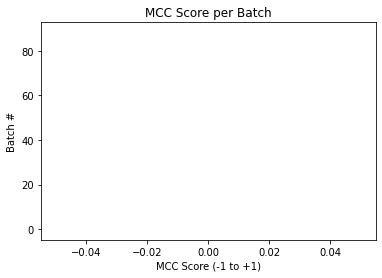

In [31]:
import seaborn as sns
def plot_mcc_per_batch(matthews_set):
    #ax = sns.barplot(x=list(range(len(matthews_set))), y=matthews_set, ci=None)
    _, ax = plt.subplots()
    ax.barh(list(range(len(matthews_set))), matthews_set, align='center')

    plt.title('MCC Score per Batch')
    plt.xlabel('MCC Score (-1 to +1)')
    plt.ylabel('Batch #')


    plt.show()

plot_mcc_per_batch(matthews_set)

References <br>
1. https://huggingface.co/transformers/model_doc/xlnet.html# <br>
2. https://mccormickml.com/2019/09/19/XLNet-fine-tuning/ <br>
3. https://github.com/zihangdai/xlnet <br>

